In [1]:
%matplotlib inline
import numpy as np
import glob
import matplotlib.pyplot as plt

In [2]:
def get_SNR(file):
    with open(file, "rt")as f:
        a = f.readlines()
    lst = []
    for x in a:
        if "Value:" in x:
            lst.append(float(x.split("Value: ")[1]))
        #print(x.split("bla"))
    lst = lst[len(lst)//2 : ]
    return (np.array(lst).mean(), np.array(lst).std())

In [3]:
def get_BER(file):
    with open(file, "rb")as f:
        _ = f.read()
    
    rcv = np.frombuffer(_, dtype = np.uint8)
    aux = np.unpackbits(rcv)
    
    tx = np.array([0, 255, 40, 250, 37, 42, 186], dtype = np.uint8)
    
    pos = np.argmax(np.correlate(np.unpackbits(rcv), np.unpackbits(tx)))
    rcv = np.packbits(np.roll(np.unpackbits(rcv), -pos))
    tx_extended = np.tile(tx, int(rcv.shape[0]/len(tx)))
    
    return (1 - np.mean(np.equal(np.unpackbits(rcv), np.unpackbits(tx_extended))))

In [4]:
def noDiffEnc_Corrector(file):
    with open(file, "rb")as f:
        _ = f.read()
    
    rcv = np.frombuffer(_, dtype = np.uint8)
    
    tx = np.array([0, 255, 40, 250, 37, 42, 186], dtype = np.uint8)
    
    pos = np.argmax(np.correlate(np.unpackbits(rcv), np.unpackbits(tx)))
    rcv = np.packbits(np.roll(np.unpackbits(rcv), -pos))
    
    new_arr = []
    tx_inverted = np.invert(tx)
    rcv_splitted = np.split(rcv, len(rcv)/len(tx))
    for x in rcv_splitted:
        comp1 = np.mean(np.equal(np.unpackbits(tx), np.unpackbits(x)))
        comp2 = np.mean(np.equal(np.unpackbits(tx_inverted), np.unpackbits(x)))
        if comp2 > comp1:
            new_arr.append(np.invert(x))
        else:
            new_arr.append(x)
    final_array = np.array(new_arr, dtype = np.uint8).ravel()
    
    tx_extended = np.tile(tx, int(rcv.shape[0]/len(tx)))
    return (1 - np.mean(np.equal(np.unpackbits(final_array), np.unpackbits(tx_extended))))

In [39]:
%%time
get_SNR("output.txt"), noDiffEnc_Corrector("output.data")

CPU times: user 6.29 s, sys: 44 ms, total: 6.34 s
Wall time: 6.34 s


((1.0239398018571428, 0.6312870184344979), 0.057216607142857145)

## <font color = red> Quanto mais baixo o SNR, maior a chance de ocorrer problemas na recepção, mais chance do resultado obtido ser ruim
    
# <font color = blue> Resultados obtidos simulados
  <font color = blue> SNR Média, SNR STD, BER


In [40]:
a = """
((7.650879285714286, 0.26635332293414554), 0.0003085714285714358)

((8.988775714285717, 0.20351008461198067), 3.776785714282305e-05)

((5.870374714285714, 0.28655551853858685), 0.0028119642857142857)

((2.872331428571429, 0.4769072630165735), 0.02530687499999995)

((1.0239398018571428, 0.6312870184344979), 0.057216607142857145)

((0.75797379, 0.692579781432908), 0.05783499999999997)
"""

In [41]:
snr_avgs = []
snr_stds = []
bers = []

for line in a.splitlines():
    aux = line.replace("(", "").replace(")", "").split(",")
    if aux != [""]:
        snr_avgs.append(float(aux[0]))
        snr_stds.append(float(aux[1]))
        bers.append(float(aux[2]))

In [42]:
def print_lst_with_slash(lst):
    print("[ \\")
    for x in lst:
        print(f"{x}, \\")
    print("]")

In [43]:
EbN0_min = 0
EbN0_max = 10
EbN0_range = range(EbN0_min, EbN0_max+1)

In [44]:
simu = np.load("simu_bpsk.npy")

In [45]:
theory = np.load("theory_bpsk.npy")

In [46]:
print(plt.style.available)

['seaborn-dark-palette', 'classic', 'seaborn-darkgrid', 'dark_background', 'seaborn', 'fast', 'seaborn-muted', 'seaborn-notebook', 'tableau-colorblind10', 'seaborn-colorblind', 'seaborn-white', 'seaborn-poster', 'grayscale', 'ggplot', 'seaborn-bright', 'Solarize_Light2', 'seaborn-whitegrid', 'seaborn-talk', '_classic_test', 'fivethirtyeight', 'seaborn-dark', 'seaborn-pastel', 'seaborn-paper', 'bmh', 'seaborn-ticks', 'seaborn-deep']


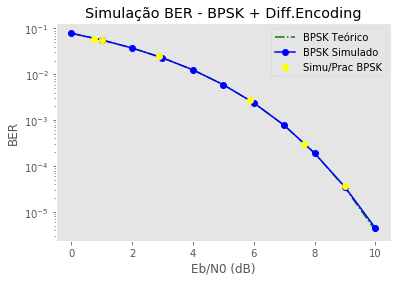

In [47]:
plt.style.use('ggplot')
plt.semilogy(EbN0_range, theory, "g-.", label = "BPSK Teórico")
plt.semilogy(EbN0_range, simu, "b-o", label = "BPSK Simulado")
plt.errorbar(snr_avgs, bers, fmt = "o", color = "yellow", label = "Simu/Prac BPSK")
plt.legend()
plt.grid()

plt.title('Simulação BER - BPSK + Diff.Encoding')
plt.xlabel('Eb/N0 (dB)')
plt.ylabel('BER')
plt.savefig("Curva.png")